In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from glob import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import wavfile
from scipy.stats import zscore

from util.path import Path
from encoding import build_regressors, SPACES
from util import subject, plot
from clean import DEFAULT_CONFOUND_MODEL, get_timinglog_run_regressors

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

from constants import TRIAL_SLICES, TR, BLU, ORG

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
sub = 5
run = None
trial = None
item = None
first = None
conv = subject.get_conv(sub)

In [4]:
eventpath = Path(
    root="data/stimuli",
    conv=conv,
    datatype="whisperx",
    run=run,
    trial=trial if trial is not None else None,
    item=item,
    condition=None,
    first=first,
    ext=".csv",
)
eventpath

data/stimuli/conv-105/whisperx/conv-105.csv

In [5]:
search_str = eventpath.starstr(['conv', 'datatype'])
print('searching for:', search_str)
files = glob(search_str)
for fn in files:
    print(fn)

searching for: data/stimuli/conv-105/whisperx/conv-105*.csv
data/stimuli/conv-105/whisperx/conv-105_run-2_trial-3_set-1_item-7_condition-G_first-A.csv
data/stimuli/conv-105/whisperx/conv-105_run-5_trial-4_set-3_item-19_condition-G_first-B.csv
data/stimuli/conv-105/whisperx/conv-105_run-4_trial-2_set-2_item-13_condition-G_first-B.csv
data/stimuli/conv-105/whisperx/conv-105_run-2_trial-1_set-1_item-5_condition-G_first-A.csv
data/stimuli/conv-105/whisperx/conv-105_run-5_trial-2_set-3_item-18_condition-G_first-A.csv
data/stimuli/conv-105/whisperx/conv-105_run-4_trial-4_set-3_item-16_condition-G_first-B.csv
data/stimuli/conv-105/whisperx/conv-105_run-3_trial-4_set-2_item-12_condition-G_first-B.csv
data/stimuli/conv-105/whisperx/conv-105_run-1_trial-1_set-1_item-1_condition-G_first-B.csv
data/stimuli/conv-105/whisperx/conv-105_run-3_trial-2_set-2_item-10_condition-G_first-A.csv
data/stimuli/conv-105/whisperx/conv-105_run-1_trial-4_set-1_item-4_condition-G_first-B.csv


In [6]:
eventpath = Path.frompath(files[0].split('/')[-1])
eventpath.update(root='stimuli', datatype='transcript')
eventpath

stimuli/conv-105/transcript/conv-105_run-2_trial-3_set-1_item-7_condition-G_first-A.csv

In [7]:
run = eventpath['run']
trial = ((int(eventpath["trial"]) - 1) % 4) + 1
run, trial = 1, 3
slices = TRIAL_SLICES
run, trial

(1, 3)

# Figure 1

In [ ]:
X, features = build_regressors(sub, spaces=SPACES['joint_split'], modelname='model-gpt2-2b_layer-24', split=True)
feature_names = list(features)
X.shape, features

((1200, 3412),
 {'task': slice(0, 2, None),
  'word_stats': slice(2, 8, None),
  'spectral': slice(8, 168, None),
  'articulation': slice(168, 212, None),
  'llm': slice(212, 3412, None)})

In [76]:
# get just one trial
Xr = X[:240]
Xt = X[slices[run-1]][:120]
Xr.shape, Xt.shape

((240, 3412), (120, 3412))

## 1a - example voxel time series

In [26]:
data = subject.get_bold(sub, cache='default_task')
run_data = data[slices[run-1]]
trial_data = run_data[:120] # get first trial always (can fix later)
trial_data.shape

(120, 81924)

In [33]:
dataB = subject.get_bold(subject.get_partner(sub), cache='default_task')
run_dataB = dataB[slices[run-1]]
trial_dataB = run_dataB[:120] # get first trial always (can fix later)
trial_dataB.shape

(120, 81924)

In [47]:
audiopath = eventpath.copy()
audiopath.update(root="data/stimuli", datatype='audio', ext='.wav')
fs, audio_data = wavfile.read(audiopath)
audio_data.shape

(2867200,)

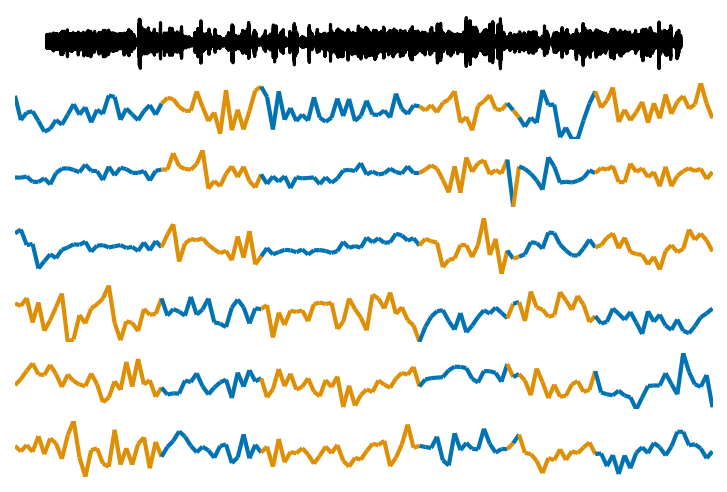

In [54]:
x = np.arange(120)

id_vars = X[slices[run-1], [1, 2]][:120]
bounds = np.diff(id_vars[:, 0]).nonzero()[0]

fig, axes = plt.subplots(7, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data), c='k')

# plot subA data
for j, i in enumerate(range(2, 5), 1):
    ax = axes[j]
    y = zscore(trial_data[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap([BLU, ORG] * (len(bounds) // 2))
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

# plot subB data
for j, i in enumerate(range(5, 8), 4):
    ax = axes[j]
    y = zscore(trial_dataB[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap([ORG, BLU] * (len(bounds) // 2))
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for ax in axes:
    ax.set_axis_off()

fig.savefig('figures/figure1/fig1a-artifacts.svg')
fig.show()

## 1b - preprocessing confound variables

In [18]:
DEFAULT_CONFOUND_MODEL

{'confounds': ['trans_x',
  'trans_y',
  'trans_z',
  'rot_x',
  'rot_y',
  'rot_z',
  'cosine'],
 'aCompCor': [{'n_comps': 5, 'tissue': 'CSF'}, {'n_comps': 5, 'tissue': 'WM'}]}

In [25]:
confounds = subject.get_confounds(sub,  runs=[run], trial_level=False, model_spec=DEFAULT_CONFOUND_MODEL)
confounds.shape 

(544, 27)

In [26]:
dft = subject.get_timing(sub, condition=None)
dft_run = dft[dft.run == run]
outputs = get_timinglog_run_regressors(sub, dft_run)

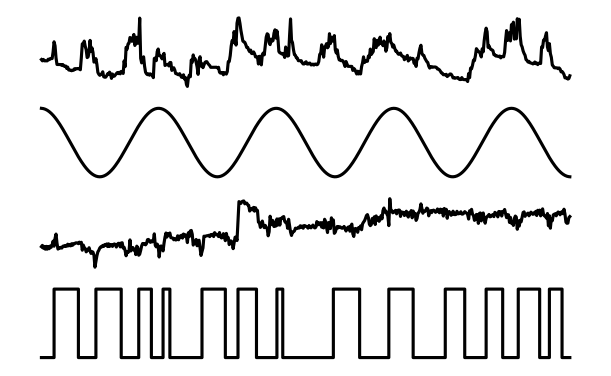

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(5, 3), sharex=True)

xaxis = np.arange(544) * 1.5

axes[0].plot(xaxis, confounds[:, 0], c='k')
axes[1].plot(xaxis, confounds[:, 14], c='k')
axes[2].plot(xaxis, confounds[:, 1], c='k')
axes[3].step(xaxis, outputs[3], c='k')

for ax in axes:
    ax.set_axis_off()
    # ax.set_xlim(TRIAL_SLICES[0])

fig.savefig('figures/figure1/fig1b-preproc-artifacts.svg')
fig.show()

## 1c - feature time series

In [72]:
features

{'task': slice(0, 8, None),
 'spectral': slice(8, 168, None),
 'articulation': slice(168, 212, None),
 'prod_llm': slice(212, 1812, None),
 'comp_llm': slice(1812, 3412, None)}

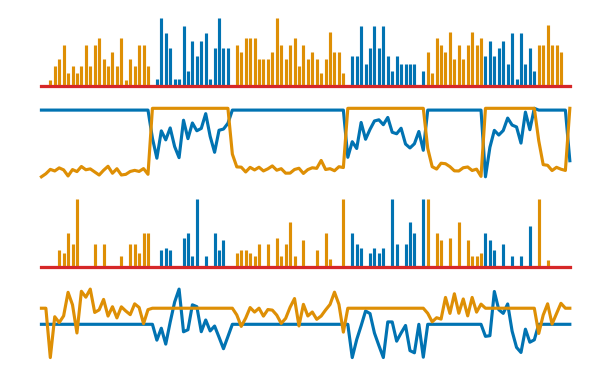

In [108]:
fig, axes = plt.subplots(4, 1, figsize=(5, 3), sharex=True)

xaxis = np.arange(120) * 1.5

# phonemes
ax = axes[0]
i = features['task'].start + 2
ax.stem(xaxis, Xt[:, i], BLU, markerfmt='')
ax = ax.twinx()
ax.stem(xaxis, Xt[:, i+4], ORG, markerfmt='')
ax.set_axis_off()

# spectral channel
i = features['spectral'].start + 1
axes[1].plot(xaxis, zscore(Xt[:, i]), c=BLU)
ax = axes[1].twinx()
ax.plot(xaxis, zscore(Xt[:, i+80]), c=ORG)
ax.set_axis_off()

# articulation channel
i = features['articulation'].start + 2
axes[2].stem(xaxis, Xt[:, i], BLU, markerfmt='')
axes[2].stem(xaxis, Xt[:, i+22], ORG, markerfmt='')

# LLM
ax = axes[3]
i = features['prod_llm'].start
ax.plot(xaxis, Xt[:, i], c=BLU)

ax = ax.twinx()
i = features['comp_llm'].start
ax.plot(xaxis, Xt[:, i], c=ORG)
ax.set_axis_off()

for ax in axes:
    ax.set_axis_off()

fig.savefig('figures/figure1/fig1c-model-artifacts.svg')
fig.show()

## 1d - model predicted time series

In [77]:
with h5py.File(f'results/encoding_default_task/sub-{sub:03d}/joint_split/sub-{sub:03d}.hdf5') as f:
    all_preds = f['cv_preds'][...]
    scores_prod = f['cv_scores_prod_exclusive'][...]
    scores_comp = f['cv_scores_comp_exclusive'][...]
all_preds.shape

(5, 5, 240, 81924)

In [78]:
np.argsort((scores_prod[0, -1] + scores_comp[0, -1]) / 2)[-5:]

array([39248, 42418, 58829, 58831, 17010])

In [85]:
preds = all_preds[0, :, :, 17010]
preds = zscore(preds, axis=1)
preds.shape

(5, 240)

In [81]:
prod_mask = Xr[:, 0].astype(bool)
comp_mask = Xr[:, 1].astype(bool)

prod_preds = preds[:, prod_mask]
comp_preds = preds[:, comp_mask]

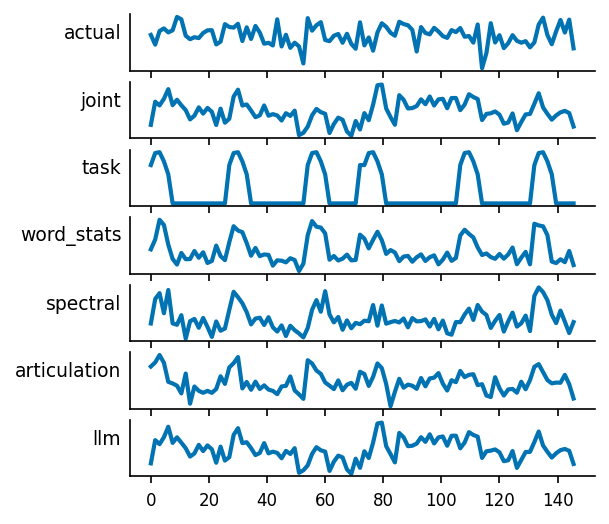

In [96]:
xaxis = np.arange(prod_mask.sum()) * 1.5
fig, axes = plt.subplots(len(features)+2, 1, figsize=(4, 4), sharex=True)

# plot actual
ax = axes[0]
ax.plot(xaxis, zscore(data[:240, 17010][prod_mask]), color=BLU, lw=2)
ax.set_ylabel('actual', rotation=0, ha='right')

# plot joint of all 
ax = axes[1]
ax.plot(xaxis, zscore(prod_preds.sum(0)), c=BLU, lw=2)
ax.set_ylabel('joint', rotation=0, ha='right')

# plot prediction of each
for i, ax in enumerate(axes[2:]):
    ax.plot(xaxis, prod_preds[i], lw=2, c=BLU)
    ax.set_ylabel(feature_names[i], rotation=0, ha='right')

for ax in axes:
    ax.set_yticks([])

fig.savefig('figures/figure1/fig1d-artifacts-prod.svg')
fig.show()

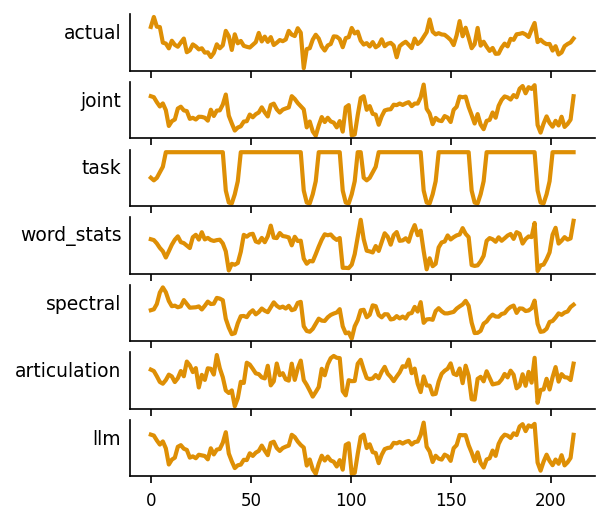

In [95]:
xaxis = np.arange(comp_mask.sum()) * 1.5
fig, axes = plt.subplots(len(features)+2, 1, figsize=(4, 4), sharex=True)

# plot actual
ax = axes[0]
ax.plot(xaxis, zscore(data[:240, 17010][comp_mask]), color=ORG, lw=2)
ax.set_ylabel('actual', rotation=0, ha='right')

# plot joint of all 
ax = axes[1]
ax.plot(xaxis, zscore(comp_preds.sum(0)), c=ORG, lw=2)
ax.set_ylabel('joint', rotation=0, ha='right')

# plot prediction of each
for i, ax in enumerate(axes[2:]):
    ax.plot(xaxis, comp_preds[i], lw=2, c=ORG)
    ax.set_ylabel(feature_names[i], rotation=0, ha='right')

for ax in axes:
    ax.set_yticks([])

fig.savefig('figures/figure1/fig1d-artifacts-comp.svg')
fig.show()

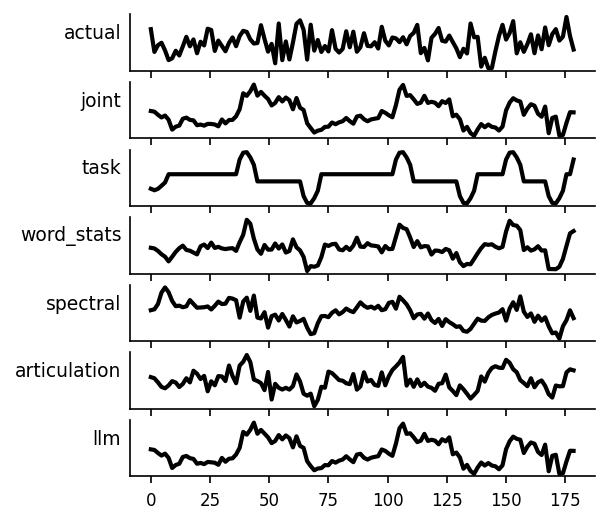

In [61]:
xaxis = np.arange(120) * 1.5
fig, axes = plt.subplots(len(features)+2, 1, figsize=(4, 4), sharex=True)

# plot actual
ax = axes[0]
ax.plot(xaxis, zscore(trial_data[:, 2]), color='k', lw=2)
ax.set_ylabel('actual', rotation=0, ha='right')

# plot joint of all 
ax = axes[1]
ax.plot(xaxis, zscore(preds.sum(0)), c='k', lw=2)
ax.set_ylabel('joint', rotation=0, ha='right')

# plot prediction of each
for i, ax in enumerate(axes[2:]):
    ax.plot(xaxis, zscore(preds[i]), lw=2, c='k')
    ax.set_ylabel(feature_names[i], rotation=0, ha='right')

for ax in axes:
    ax.set_yticks([])

# fig.savefig('figures/figure1/fig1d-artifacts.svg')
fig.show()

## brain

In [6]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

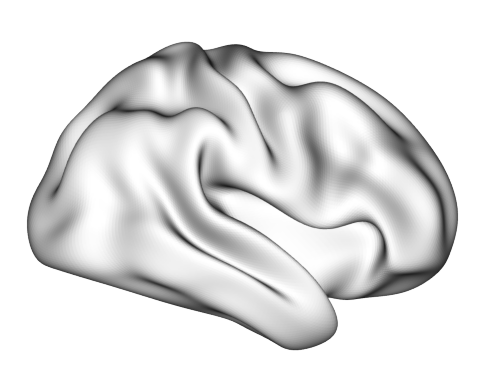

In [33]:
p = Plot(surf_rh=rh, views='lateral', brightness=0.8)
fig = p.build()
# fig.savefig('figures/fig1a-brain.svg')

In [45]:
cmap = sns.color_palette('colorblind').as_hex()
print(cmap[0])
print(cmap[3])
print(cmap[4])
cmap

#0173b2
#d55e00
#cc78bc


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [18]:
from util.plot import get_surfplot

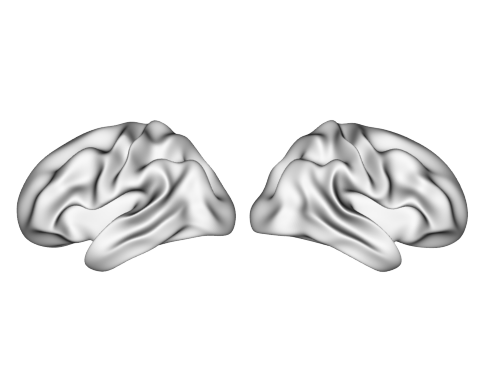

In [26]:
p = get_surfplot(views='lateral', zoom=1.2, inflation=50, sulc_alpha=0, brightness=0.75)
fig = p.build()
fig.show()

# Figure 3

In [13]:
sub, run, trial, slices

(5,
 3,
 4,
 [slice(0, 240, None),
  slice(240, 480, None),
  slice(480, 720, None),
  slice(720, 960, None),
  slice(960, 1200, None)])

In [14]:
subB = subject.get_partner(sub)
subB

105

In [34]:
with h5py.File('encoding/trialmot6/sub-005/model-opt-7b_layer-23/sub-005.hdf5', 'r') as f:
    subA_prod_preds = f['cv_preds'][run-1, -2, :120, 5]
    subA_comp_preds = f['cv_preds'][run-1, -1, :120, 5]
subA_prod_preds.shape

(120,)

In [27]:
with h5py.File('encoding/trialmot6/sub-105/model-opt-7b_layer-23/sub-105.hdf5', 'r') as f:
    subB_preds = f['cv_preds'][run-1, :-2, :120, 5].sum(0)
subB_preds.shape

(120,)

In [29]:
actual_b = trial_dataB[:, 5]
actual_b.shape

(120,)

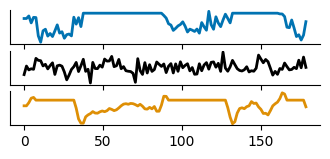

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(4, 1.5), sharex=True)

xaxis = np.arange(120) * 1.5
axes[0].plot(xaxis, zscore(subA_prod_preds), color=BU, lw=2)
axes[1].plot(xaxis, zscore(actual_b - subB_preds), c='k', lw=2)
axes[2].plot(xaxis, zscore(subA_comp_preds), color=OR, lw=2)

for ax in axes:
    ax.set_yticks([])
sns.despine(fig)
fig.savefig('figures/fig3a-artifacts.svg')
fig.show()

# language hierarchy

In [9]:
from nltk.corpus import cmudict
arpabet = cmudict.dict()

In [2]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [16]:
doc = nlp("I put the lasagna in.")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.morph, arpabet.get(token.text.lower(), [None])[0])


I I PRON PRP nsubj Case=Nom|Number=Sing|Person=1|PronType=Prs ['AY1']
put put VERB VBD ROOT Tense=Past|VerbForm=Fin ['P', 'UH1', 'T']
the the DET DT det Definite=Def|PronType=Art ['DH', 'AH0']
lasagna lasagna PROPN NNP dobj Number=Sing ['L', 'AA0', 'S', 'AA1', 'N', 'Y', 'AH0']
in in ADP RP prt  ['IH0', 'N']
. . PUNCT . punct PunctType=Peri None


In [17]:
displacy.render(doc, style='dep')

# Custom atlas ROIS

In [13]:
import sys
from importlib import reload
reload(sys.modules['util.plot'])

from util.atlas import Atlas
from util import plot

fslr_params = dict(surface='fslr', density='32k', transform='fsaverage_to_fslr')

In [3]:
# from LanAtlas paper SI-I fig
rois = {
    'LH_SM': [f'L_{l}_ROI' for l in ['3b', '3a', '4']],
    'LH_EarlyAud': ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'],
    'LH_AntTemp': [f'L_{l}_ROI' for l in ['TA2', 'STSva', 'STSda', 'STGa', 'Pl', 'A5']],
    'LH_PostTemp': [f'L_{l}_ROI' for l in ['TPOJ1', 'TPOJ2', 'STV', 'STSvp', 'STSdp', 'PSL', 'PHT', 'PGi']],
    'LH_MFG': [f'L_{l}_ROI' for l in ['FEF', '55b']],
    'LH_IFG': [f'L_{l}_ROI' for l in ['IFSp', 'IFJa', '44']],
    'LH_IFGorb': [f'L_{l}_ROI' for l in ['47l', '45']],
    'LH_AngG': [f'L_{l}_ROI' for l in ['TPOJ3', 'PGs']],
    'LH_PMC': [f'L_{l}_ROI' for l in ['31a', '31pd', '31pv']],
    'LH_PreCun': ['L_POS2_ROI'],
}
flip = lambda x: ['R' + r[1:] for r in x]
rois |= {k.replace('LH_', 'RH_') : flip(v) for k, v in rois.items()}
len(rois)

20

In [6]:
atlas = Atlas.glasser2016()
label_img = np.zeros_like(atlas.label_img)
labels = {0: '???'}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = atlas.roimask(v)
    print(i, k, v, mask.sum())
    label_img[mask] = i
    labels[i] = k
custom_atlas = Atlas('custom', label_img, labels)

1 LH_SM ['L_3b_ROI', 'L_3a_ROI', 'L_4_ROI'] 2166
2 LH_EarlyAud ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'] 818
3 LH_AntTemp ['L_TA2_ROI', 'L_STSva_ROI', 'L_STSda_ROI', 'L_STGa_ROI', 'L_Pl_ROI', 'L_A5_ROI'] 681
4 LH_PostTemp ['L_TPOJ1_ROI', 'L_TPOJ2_ROI', 'L_STV_ROI', 'L_STSvp_ROI', 'L_STSdp_ROI', 'L_PSL_ROI', 'L_PHT_ROI', 'L_PGi_ROI'] 1905
5 LH_MFG ['L_FEF_ROI', 'L_55b_ROI'] 371
6 LH_IFG ['L_IFSp_ROI', 'L_IFJa_ROI', 'L_44_ROI'] 442
7 LH_IFGorb ['L_47l_ROI', 'L_45_ROI'] 399
8 LH_AngG ['L_TPOJ3_ROI', 'L_PGs_ROI'] 430
9 LH_PMC ['L_31a_ROI', 'L_31pd_ROI', 'L_31pv_ROI'] 350
10 LH_PreCun ['L_POS2_ROI'] 302
11 RH_SM ['R_3b_ROI', 'R_3a_ROI', 'R_4_ROI'] 2050
12 RH_EarlyAud ['R_A1_ROI', 'R_A4_ROI', 'R_LBelt_ROI', 'R_PBelt_ROI', 'R_MBelt_ROI'] 643
13 RH_AntTemp ['R_TA2_ROI', 'R_STSva_ROI', 'R_STSda_ROI', 'R_STGa_ROI', 'R_Pl_ROI', 'R_A5_ROI'] 795
14 RH_PostTemp ['R_TPOJ1_ROI', 'R_TPOJ2_ROI', 'R_STV_ROI', 'R_STSvp_ROI', 'R_STSdp_ROI', 'R_PSL_ROI', 'R_PHT_ROI', 'R_PGi_ROI']

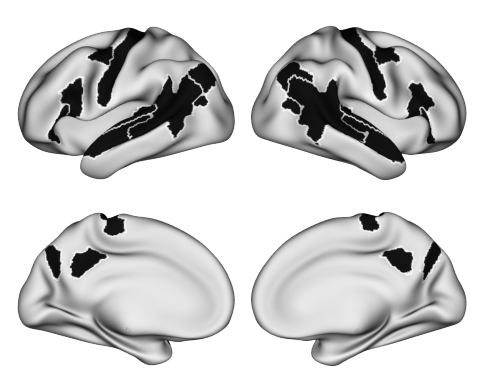

In [15]:
all_mask = (label_img > 0).astype(np.int32)
fig = plot.surface_plot(all_mask, atlas=custom_atlas, vmin=0, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
fig.savefig('figures/fig3-atlas-legend.svg')

In [ ]:
for label in custom_atlas.labels:
    mask = custom_atlas.roimask([label]).astype(np.int32)
    fig = plot.surface_plot(mask, vmin=0, vmax=1, cmap='Greys', cbar=False, sulc_alpha=0.2, **fslr_params)
    fig.suptitle(label)
    fig.show()

# colorbars

In [14]:
from matplotlib.colors import LinearSegmentedColormap

colors = [ORG, '#ffffff', BLU]
cmap = LinearSegmentedColormap.from_list("custom_BuOg", colors)

In [3]:
maps = ['magma', 'hot']#, 'inferno', 'Spectral', 'Spectral_r', cmap]
# maps = [cmap]

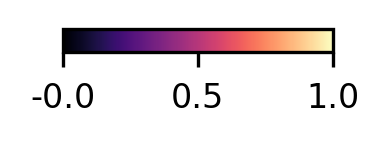

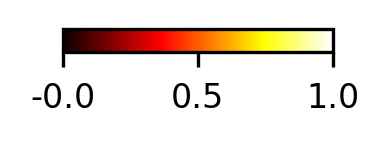

In [4]:
for cmap_name in maps:
    cmap = plt.get_cmap(cmap_name)
    name = cmap.name
    fig = plot.standalone_colorbar(cmap, ticks=(0, .5, 1), tick_labels=(-0.0, .50, 1.0), figsize=(1, .75), font_size=8)
    fig.savefig(f'figures/colorbars/cbar-{name}.svg')

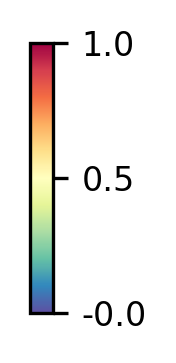

In [19]:
cmap = 'Spectral_r'
fig = plot.standalone_colorbar(cmap, orientation='v', ticks=(0, .5, 1), tick_labels=(-0.0, .50, 1.0), figsize=(1, .75), font_size=8)
fig.savefig(f'figures/cbar-{cmap}-vertical.svg')

# testing clean: run-level confounds

In [9]:
from constants import RUN_TRIAL_SLICE, RUN_TRS
from nilearn.glm.first_level import glover_hrf

In [11]:
kernel = glover_hrf(TR, oversampling=1)

In [12]:
def get_timinglog_run_regressors(sub_id: int, dft_run: pd.DataFrame):

    # trial boxcar
    trial_boxcar = np.zeros(RUN_TRS)
    for _, trial_slice in RUN_TRIAL_SLICE.items():
        trial_boxcar[trial_slice] = 1

    # prompt boxcar
    prompt_boxcar = np.zeros(RUN_TRS)
    for _, trial_slice in RUN_TRIAL_SLICE.items():
        prompt_slice = slice(trial_slice.start - 6, trial_slice.start)
        prompt_boxcar[prompt_slice] = 1

    screen_change = np.abs(np.diff(prompt_boxcar, prepend=0))

    speaker_role = "speaker" if sub_id > 100 else "listener"
    listener_role = "listener" if sub_id > 100 else "speaker"

    # create speaking and listening boxcars
    speech_onsets = (dft_run["run.time"] / TR).astype(int).to_numpy()
    button_press = np.zeros(RUN_TRS)
    receive_press = np.zeros(RUN_TRS)
    speech_boxcar = np.zeros(RUN_TRS)
    listen_boxcar = np.zeros(RUN_TRS)
    for i in range(len(speech_onsets) - 1):
        start = speech_onsets[i]
        stop = speech_onsets[i + 1]
        if dft_run.iloc[i]["role"] == speaker_role:
            speech_boxcar[start:stop] = 1
        elif dft_run.iloc[i]["role"] == listener_role:
            listen_boxcar[start:stop] = 1

        if dft_run.iloc[i]["role"] == speaker_role and dft_run.iloc[i+1]["role"] == listener_role:
            button_press[stop] = 1
            screen_change[start] = 1
            screen_change[stop] = 1
        if dft_run.iloc[i]["role"] == listener_role and dft_run.iloc[i+1]["role"] == speaker_role:
            receive_press[stop] = 1
            screen_change[start] = 1
            screen_change[stop] = 1


    return [trial_boxcar, prompt_boxcar, speech_boxcar, listen_boxcar, button_press, receive_press, screen_change]

In [13]:
sub_id = 120
sub_id = 5
dft = subject.get_timing(sub_id, condition=None)
dft_run = dft[dft.run == 1]
outputs = get_timinglog_run_regressors(sub_id, dft_run)

In [14]:
design_confounds = [np.convolve(conf, kernel, mode='full')[:RUN_TRS] for conf in outputs]
len(design_confounds[0])

544

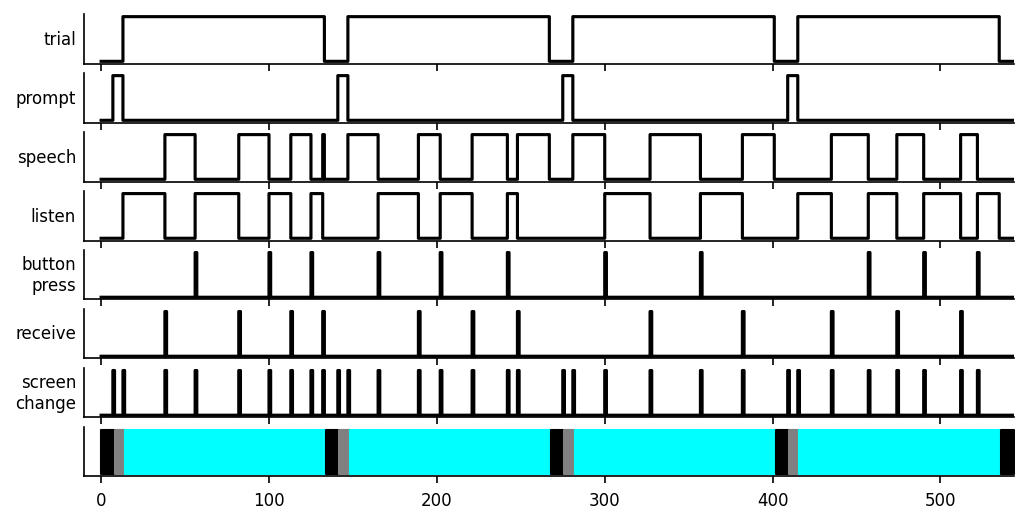

In [15]:
xaxis = np.arange(544)
labels = ['trial', 'prompt', 'speech', 'listen', 'button\npress', 'receive', 'screen\nchange']

fig, axes = plt.subplots(len(outputs) + 1, 1, figsize=(8, 4), sharex=True)

for ax, nuisance, label in zip(axes, outputs, labels):
    ax.step(xaxis, nuisance, c='k')
    ax.set_ylabel(label, rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=8)

# structure
colors = ['gray', 'cyan', 'black']
ax = axes[-1]
ax.fill_between([0, 8], [0], [0.5], color=colors[-1])
start = 8
for i in range(4):
    for j, color in zip([6, 120, 8], colors):
        ax.fill_between([start, start+j], [0], [0.5], color=color)
        start += j

for ax in axes:
    ax.set_yticks([])
    ax.set_xlim(-10, 544)
    # ax.grid()

fig.savefig('figures/figure1/design-confounds.svg')
fig.show()

## hrf test

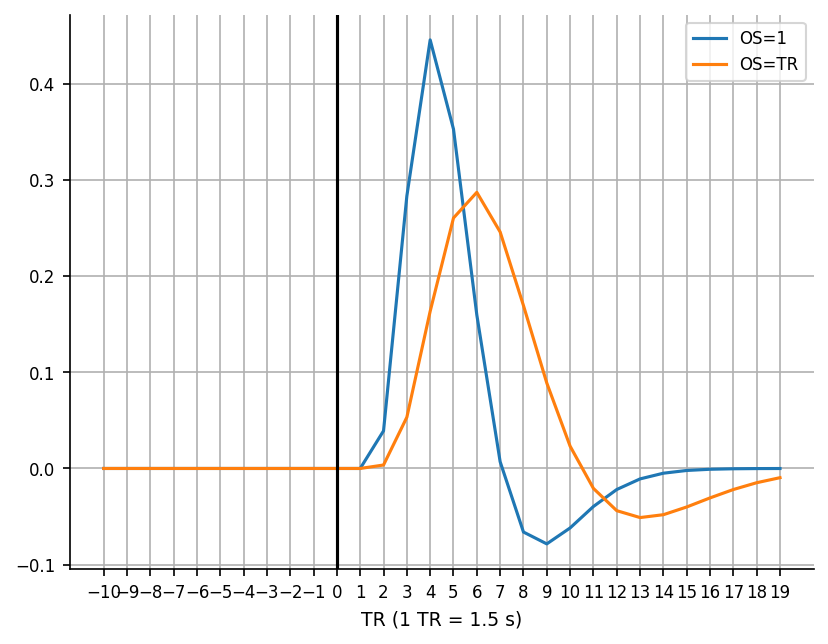

In [16]:
x = np.zeros(30)
x[10] = 1

xaxis = np.arange(-10, 20)
plt.plot(xaxis, np.convolve(x, glover_hrf(TR, oversampling=1), mode='full')[:30], label='OS=1')
plt.plot(xaxis, np.convolve(x, glover_hrf(TR, oversampling=TR), mode='full')[:30], label='OS=TR')
# plt.axvline(y.argmax() - 10)
plt.xticks(xaxis)
plt.grid()
plt.xlabel("TR (1 TR = 1.5 s)")
plt.axvline(0, c='k')
plt.legend(frameon=True)
plt.show()